# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

In [183]:
import numpy as np
import matplotlib.pyplot as plt

In [184]:
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]


# load the test set
test = np.loadtxt('data/synth_test.txt')
class_test = test[:,0]
x_test = test[:,1:]
N_test = test.shape[0]


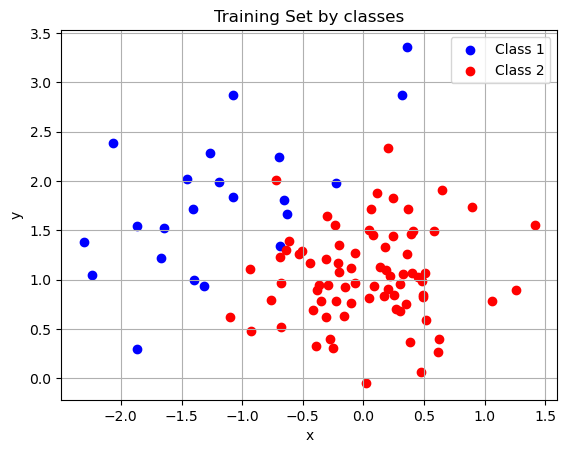

In [185]:
# separate the training set by classes
x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]

# Plot the training set and distinguish the two classes
plt.figure()
plt.scatter(x_train_class1[:,0], x_train_class1[:,1],
            color='blue', label='Class 1')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1],
            color='red', label='Class 2')

plt.title('Training Set by classes')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


```python
import numpy as np
import bottleneck as bn

# Create a random array
arr = np.random.rand(10)
N = 3  # Number of smallest elements to retrieve

# Using np.argsort() to get indices of the first N elements
sorted_indices = np.argsort(arr)[:N]

# Using bottleneck.argpartition() to get the first N smallest indices
partitioned_indices = bn.argpartition(arr, N)[:N]

# Display the results
print("Original array:", arr)
print("Indices using np.argsort:", sorted_indices)
print("First N elements using np.argsort:", arr[sorted_indices])

print("Indices using bottleneck.argpartition:", partitioned_indices)
print("First N elements using bottleneck.argpartition:", arr[partitioned_indices])

are_equal = set(arr[sorted_indices]) == set(arr[partitioned_indices])
print(are_equal)
```


**Answer:**

**1. Explanation of the Calculation of the Norm**

First, we use `x_test[i, np.newaxis]` because when we take a single test point `x_test[i]`, its shape is: $(2,)$ i.e., a 1D array, but the training set `x_train` has shape: $(N_{\text{train}}, 2)$ i.e., a 2D array.

To make the subtraction explicit, we reshape the test point into a row vector of shape $(1,2)$.

Then we compute the distance using `np.linalg.norm(..., axis=1)`, which calculates the Euclidean norm across columns (axis=1), so the distance is computed in the 2-dimensional feature space. We chose to use the Euclidean distance by default since we do not know the particularities of the dataset, but the best distance metric could be selected using cross-validation.

**3. How to get the Mode**

In order to get the mode, `np.bincount(labels)` counts how many times each integer label appears in the array and returns an array where the value at each index is the number of times that index (label) occurs. 

If there is a tie between two classes, we chose the class whose nearest point is the closest (not necessarily the globally closest point in the dataset, but the closest within the tied classes)

Then, `np.argmax(counts)` gives the index with the highest count ie the mode.


In [186]:
import bottleneck as bn

In [ ]:
def knn_classify(x_train, class_train, x_test, k):
    """
    K-Nearest Neighbours classifier

    Args:
        x_train (array): Training features (n_samples, n_features)
        class_train (array): Training labels (n_samples,)
        x_test (array): Test features (m_samples, n_features)
        k (int): Number of nearest neighbours

    Returns:
        class_pred (array): Predicted labels for x_test (m_samples,)
    """

    N_test = x_test.shape[0]
    class_pred = np.zeros(N_test, dtype=int) # Initializating an array of shape N_test to store predicted labels for each point

    for i in range(N_test):

        # Compute distances between x_test[i] and all training points
        distances = np.linalg.norm(x_train - x_test[i, np.newaxis], axis=1)

        # Get indices of the k smallest distances
        # indices = np.argsort(distances)[:k]    #indices that would sort the array
        indices = bn.argpartition(distances, k)[:k]

        # Get the labels of these k neighbours and convert to int because np.bincount works only with non negative ints
        labels = class_train[indices].astype(int)

        # Return the mode for KNN
        counts = np.bincount(labels)   # counts how many of each label

        # If there is a tie, we choose the label of the closest neighbour among the tied classes
        if np.sum(counts == np.max(counts)) > 1:
            tied_classes = np.where(counts == np.max(counts))[0]  # classes involved in the tie
            # Find the closest neighbour among the tied classes
            closest_idx = np.argmin([np.min(distances[indices][class_train[indices] == c]) for c in tied_classes])
            class_pred[i] = tied_classes[closest_idx]

        else :
            class_pred[i] = np.argmax(counts)  # index of max count = mode

    return class_pred


3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

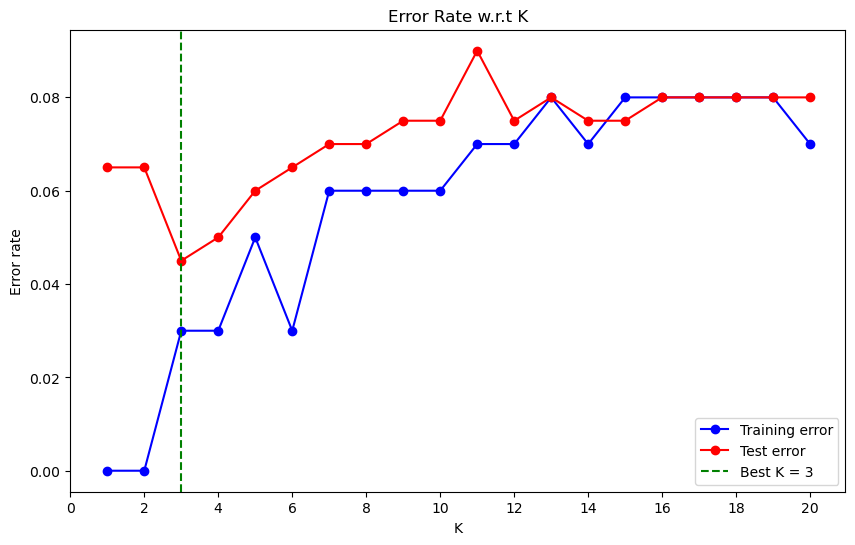

Best k = 3 with test error 4.50%


In [188]:
# Compute the error for several values of k

K = [k for k in range (1,21)]
errors_train = []
errors_test = []

for k in K:
    # Predictions on training set
    pred_train = knn_classify(x_train, class_train, x_train, k=k)
    # Predictions on test set
    pred_test = knn_classify(x_train, class_train, x_test, k=k)

    # Compare predicted labels to true labels
    # (pred_train != class_train) returns a Boolean array with True for wrong predictions and False for correct ones
    # np.mean converts True=1 and False=0 and compute the means ie it returns the fraction of wrong predictions -> 0-1 loss
    err_train  = np.mean(pred_train != class_train)
    err_test = np.mean(pred_test != class_test)

    errors_train.append(err_train)
    errors_test.append(err_test)

# Best K (lowest test error)
best_k = K[np.argmin(errors_test)]

# Plot error rates
plt.figure(figsize=(10, 6))
plt.plot(K, errors_train, marker='o', color='blue', label='Training error')
plt.plot(K, errors_test, marker='o', color='red', label='Test error')

# Force integer ticks on x-axis (1 to 20)
plt.xticks(np.arange(0, 21, 2))

# Highlight best K with a vertical line
plt.axvline(x=best_k, color='green', linestyle="--", label=f"Best K = {best_k}")

plt.xlabel('K')
plt.ylabel('Error rate')
plt.title('Error Rate w.r.t K')
plt.grid(False)
plt.legend()
plt.show()

print(f"Best k = {best_k} with test error {min(errors_test):.2%}")

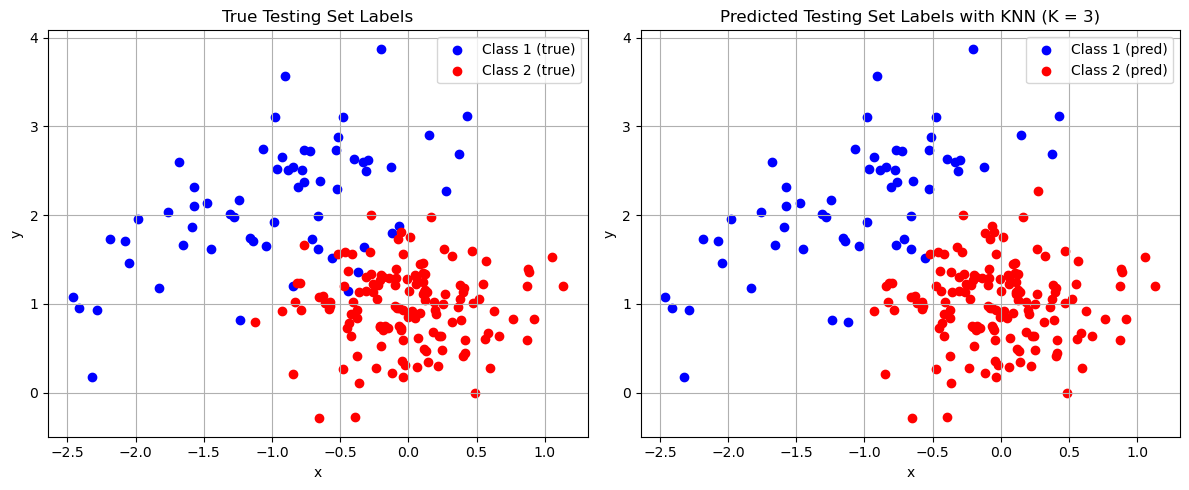

In [189]:
# Show classification result for the best K
pred_best = knn_classify(x_train, class_train, x_test, k=best_k)

# Separate test points by predicted class
x_test_pred1 = x_test[pred_best == 1]
x_test_pred2 = x_test[pred_best == 2]

# Separate test points by true class
x_test_true1 = x_test[class_test == 1]
x_test_true2 = x_test[class_test == 2]

# Plot the training set and distinguish the two classes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(x_test_true1[:, 0], x_test_true1[:, 1],
                color='blue', label='Class 1 (true)')
axes[0].scatter(x_test_true2[:, 0], x_test_true2[:, 1],
                color='red', label='Class 2 (true)')
axes[0].set_title('True Testing Set Labels')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(x_test_pred1[:, 0], x_test_pred1[:, 1],
                color='blue', label='Class 1 (pred)')
axes[1].scatter(x_test_pred2[:, 0], x_test_pred2[:, 1],
                color='red', label='Class 2 (pred)')
axes[1].set_title(f'Predicted Testing Set Labels with KNN (K = {best_k})')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Most errors occur in areas where the two classes are mixed or are very close to each other.

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

In [190]:
print("Best K:", best_k)

Best K: 3


For small $K$, the training error is very low because the model memorizes the training points. This often causes overfitting and poor performance on the test set.

As $K$ increases, the training error rises a bit while the test error first decreases (less overfitting) and then increases again (too much averaging).

The best $K$ is the one with the lowest test error, as it gives the best generalization to new data. In our case, this happens at $K=3$.


5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [191]:
from sklearn.neighbors import KNeighborsClassifier
import timeit

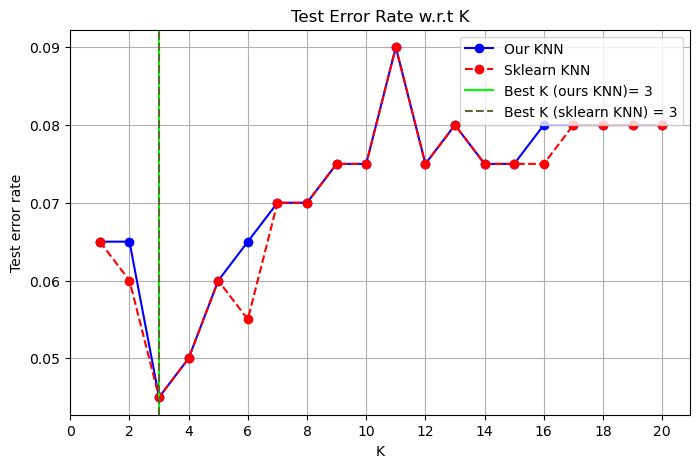

Best k with our KNN = 3 with test error 4.50%
Best k with sklearn's KNN = 3 with test error 4.50%


In [202]:
K = [k for k in range(1,21)]
errors_test_knn = []
errors_test_sklearn = []
times_knn = []
times_sklearn = []

for k in K:
    # our implementation
    start = timeit.default_timer()
    pred_knn = knn_classify(x_train, class_train, x_test, k=k)
    stop = timeit.default_timer()
    times_knn.append(stop - start)
    errors_test_knn.append(np.mean(pred_knn != class_test))

    # sklearn implementation
    start = timeit.default_timer()
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x_train, class_train)
    pred_sklearn = clf.predict(x_test)
    stop = timeit.default_timer()
    times_sklearn.append(stop - start)
    errors_test_sklearn.append(np.mean(pred_sklearn != class_test))

# Best K
best_k_knn = K[np.argmin(errors_test_knn)]
best_k_sklearn = K[np.argmin(errors_test_sklearn)]

# Plot error rates
plt.figure(figsize=(8,5))
plt.plot(K, errors_test_knn, 'o-', color = 'blue', label='Our KNN')
plt.plot(K, errors_test_sklearn, 'o--', color = 'red', label='Sklearn KNN')

# Force integer on x-axis (1 to 20)
plt.xticks(np.arange(0, 21, 2))

# Highlight best K with a vertical line
plt.axvline(x=best_k_knn, color='lime', linestyle='-', label=f'Best K (ours KNN)= {best_k_knn}')
plt.axvline(x=best_k_sklearn, color='darkolivegreen', linestyle='--', label=f'Best K (sklearn KNN) = {best_k_sklearn}')


plt.xlabel('K')
plt.ylabel('Test error rate')
plt.title('Test Error Rate w.r.t K')
plt.grid(True)
plt.legend()
plt.show()

print(f"Best k with our KNN = {best_k_knn} with test error {min(errors_test_knn):.2%}")
print(f"Best k with sklearn's KNN = {best_k_sklearn} with test error {min(errors_test_sklearn):.2%}")

The test error rates obtained with our KNN implementation and with scikit-learn’s KNN are almost the same for K in $\{1,2, \dotsc, 20\}$, with for K in $\{2,6,16\}$ better performance of scikit-learn's KNN.

In particular, both methods reach their minimum test error at the same value of $K=3$. Thus our implementation reproduces correctly a KNN classification.

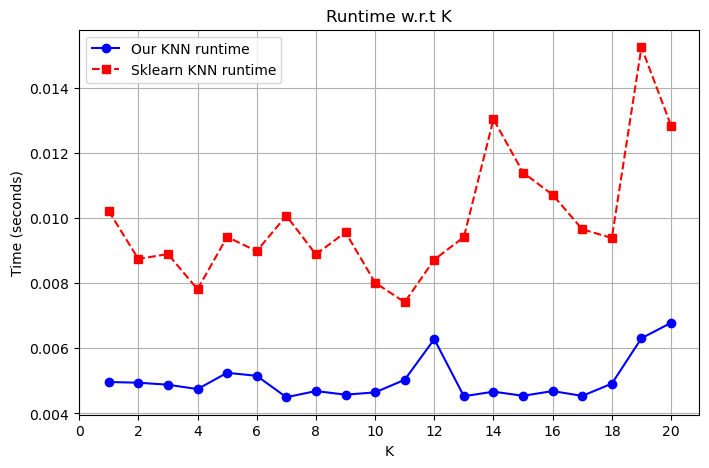

In [203]:
# Plot runtimes
plt.figure(figsize=(8,5))
plt.plot(K, times_knn, 'o-', color = 'blue', label='Our KNN runtime')
plt.plot(K, times_sklearn, 's--', color = 'red',  label='Sklearn KNN runtime')
plt.xlabel('K')
plt.ylabel('Time (seconds)')
plt.title('Runtime w.r.t K')
plt.xticks(np.arange(0, 21, 2))
plt.grid(True)
plt.legend()
plt.show()


Our KNN implementation usually runs faster than scikit-learn’s KNN for K in $\{1,2, \dotsc, 20\}$ and on small datasets because it is simpler and uses fully vectorized NumPy operations, without the extra overhead that scikit-learn includes for generality and flexibility.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


According to the details provided in `data/wdbc12.names.txt`, column 0 is the **ID**, column 1 is the **diagnosis** (i.e., the label: 2 = benign, 1 = malignant), and the remaining columns contain the **features**.


In [195]:
#load data
data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
print(data[:1]) #print the first row of the data to see its structure

# Labels (diagnosis)
class_wdbc = data[:, 1] # column 1 = diagnosis

# Features
x_wdbc = data[:, 2:]  # columns 2+ = features

N_wdbc = data.shape[0]

[[8.42302e+05 1.00000e+00 1.79900e+01 1.03800e+01 1.22800e+02 1.00100e+03
  1.18400e-01 2.77600e-01 3.00100e-01 1.47100e-01 2.41900e-01 7.87100e-02
  1.09500e+00 9.05300e-01 8.58900e+00 1.53400e+02 6.39900e-03 4.90400e-02
  5.37300e-02 1.58700e-02 3.00300e-02 6.19300e-03 2.53800e+01 1.73300e+01
  1.84600e+02 2.01900e+03 1.62200e-01 6.65600e-01 7.11900e-01 2.65400e-01
  4.60100e-01 1.18900e-01]]


In [196]:
# Split the data into 2 set for training and testing
seed = 42

x_train_wdbc, x_test_wdbc, class_train_wdbc, class_test_wdbc = train_test_split(
    x_wdbc, class_wdbc,
    test_size=0.3, random_state=seed,
    stratify=class_wdbc
)

print("Training set:", x_train_wdbc.shape, class_train_wdbc.shape)
print("Test set:", x_test_wdbc.shape, class_test_wdbc.shape)

Training set: (398, 30) (398,)
Test set: (171, 30) (171,)


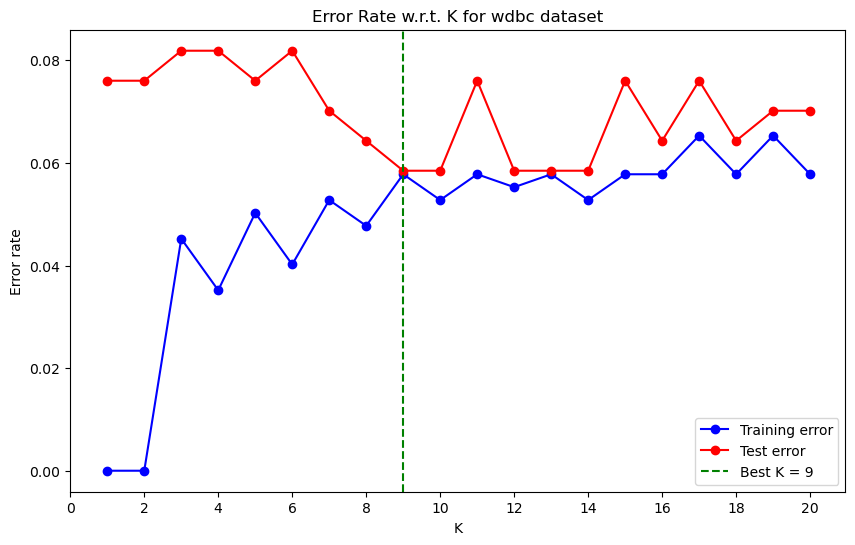

In [197]:
# Finding the best k

K = [k for k in range (1,21)]
errors_train_wdbc = []
errors_test_wdbc = []

for k in K:
    # Predictions on training set
    pred_train_wdbc = knn_classify(x_train_wdbc, class_train_wdbc, x_train_wdbc, k=k)

    # Predictions on test set
    pred_test_wdbc = knn_classify(x_train_wdbc, class_train_wdbc, x_test_wdbc, k=k)

    # Compute the error rates
    err_train_wdbc = np.mean(pred_train_wdbc != class_train_wdbc)
    err_test_wdbc = np.mean(pred_test_wdbc != class_test_wdbc)

    errors_train_wdbc.append(err_train_wdbc)
    errors_test_wdbc.append(err_test_wdbc)

# Best K (lowest test error)
best_k_wdbc = K[np.argmin(errors_test_wdbc)]

# Plot error rates
plt.figure(figsize=(10, 6))
plt.plot(K, errors_train_wdbc, marker='o', color='blue', label='Training error')
plt.plot(K, errors_test_wdbc, marker='o', color='red', label='Test error')

# Force integer ticks on x-axis (1 to 20)
plt.xticks(np.arange(0, 21, 2))

# Highlight best K with a vertical line
plt.axvline(x=best_k_wdbc, color='green', linestyle="--", label=f"Best K = {best_k_wdbc}")

plt.xlabel('K')
plt.ylabel('Error rate')
plt.title('Error Rate w.r.t. K for wdbc dataset')
plt.grid(False)
plt.legend()
plt.show()


Test error with K=9: 5.85%


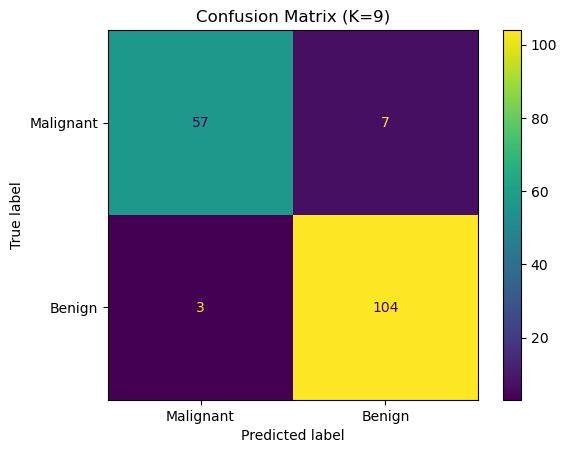

In [198]:
# Final evaluation on the test set with the best K
pred_test_best = knn_classify(x_train_wdbc, class_train_wdbc, x_test_wdbc, k=best_k_wdbc)

final_error = np.mean(pred_test_best != class_test_wdbc)
print(f"Test error with K={best_k_wdbc}: {final_error:.2%}")

# Confusion matrix for the best K
cm = confusion_matrix(class_test_wdbc, pred_test_best)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malignant','Benign']).plot()
plt.title(f'Confusion Matrix (K={best_k_wdbc})')
plt.show()


The confusion matrix shows that the our KNN classifier correctly predicted most of the malignant and benign cases. The diagonal elements represent correct classifications, while off-diagonal elements indicate misclassifications.

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [199]:
!cd example_cy && python setup.py build_ext --inplace

error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/


In [200]:
import example_cy.helloworld as toy

toy.printhello()

ModuleNotFoundError: No module named 'example_cy.helloworld'

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

which should display
```python
Hello World
```

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [ ]:
# your code

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [ ]:
# your code

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [ ]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [ ]:
# your code